In [1]:
import os
import gdown
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import pickle
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


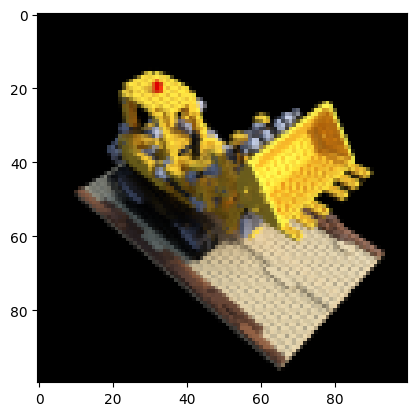

In [3]:
torch.manual_seed(0)
# Load input images, poses, and intrinsics
data = np.load("lego_data.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
poses = data["poses"]
poses = torch.from_numpy(poses).to(device)

gt_poses = poses.clone()


# Peturb Poses
poses[:100,0:3,3] += 0.2*torch.randn_like(poses[:100,0:3,3])



# Camera intrinsics
intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)

# Hold one image out (for test).
test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

In [4]:
def positional_encoding(x, num_frequencies=6, incl_input=True):


    results = []
    if incl_input:
        results.append(x)
    freq = (2**torch.arange(num_frequencies, device=device))*torch.pi
    sin = torch.sin(x.reshape(-1,1)*freq)
    cos = torch.cos(x.reshape(-1,1)*freq)
    results.append(sin.reshape(x.shape[0],-1))
    results.append(cos.reshape(x.shape[0],-1))
    return torch.cat(results, dim=-1)

In [5]:
def get_rays(height, width, intrinsics, w_R_c, w_T_c):


    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  
    ray_origins = torch.zeros((height, width, 3), device=device) 
    H, W = torch.meshgrid((torch.arange(height),torch.arange(width)), indexing='xy')
    pix_coords = torch.vstack((H.flatten(),W.flatten(),torch.ones(len(H.flatten())))).to(device)
    Pc = torch.linalg.inv(intrinsics)@pix_coords
    ray_directions = ((w_R_c@Pc).T).reshape(height,width,3)
    ray_directions = ray_directions/torch.norm(ray_directions, dim=2).unsqueeze(dim=2)
    ray_origins = torch.broadcast_to(w_T_c,ray_directions.shape)

    return ray_origins, ray_directions

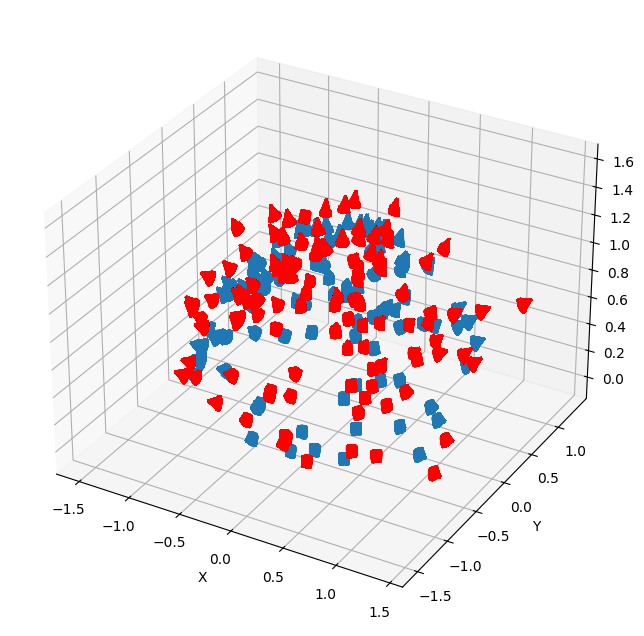

In [6]:
def plot_all_poses(poses, gt_poses):

    origins = []
    directions = []
    for pose in poses:
      ray_origins, ray_directions = get_rays(height, width, intrinsics, pose[0:3,0:3], pose[0:3,3])
      origins.append(ray_origins)
      directions.append(ray_directions)
    origins = torch.cat(origins).cpu()
    directions = torch.cat(directions).cpu()

    gt_origins = []
    gt_directions = []
    for gt_pose in gt_poses:
      ray_origins, ray_directions = get_rays(height, width, intrinsics, gt_pose[0:3,0:3], gt_pose[0:3,3])
      gt_origins.append(ray_origins)
      gt_directions.append(ray_directions)
    gt_origins = torch.cat(gt_origins).cpu()
    gt_directions = torch.cat(gt_directions).cpu()


    ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
    _ = ax.quiver(origins[..., 0].flatten(),
                  origins[..., 1].flatten(),
                  origins[..., 2].flatten(),
                  directions[..., 0].flatten(),
                  directions[..., 1].flatten(),
                  directions[..., 2].flatten(), length=0.12, normalize=True, color='red')

    _ = ax.quiver(gt_origins[..., 0].flatten(),
                  gt_origins[..., 1].flatten(),
                  gt_origins[..., 2].flatten(),
                  gt_directions[..., 0].flatten(),
                  gt_directions[..., 1].flatten(),
                  gt_directions[..., 2].flatten(), length=0.12, normalize=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('z')
    plt.show()

plot_all_poses(poses, gt_poses)

In [6]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):


    i = torch.arange(samples, device=device)/samples
    t = near + i*(far-near)
    ray_points = (ray_origins.unsqueeze(-1) + ray_directions.unsqueeze(-1)*t).permute(0,1,3,2)
    depth_points = torch.broadcast_to(t,ray_points.shape[:-1])

    return ray_points, depth_points

In [7]:
class nerf_model(nn.Module):

    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()

        self.layers = nn.ModuleDict({
            'layer_1': nn.Linear(6*num_x_frequencies+3,filter_size),
            'layer_2': nn.Linear(filter_size,filter_size),
            'layer_3': nn.Linear(filter_size,filter_size),
            'layer_4': nn.Linear(filter_size,filter_size),
            'layer_5': nn.Linear(filter_size,filter_size),
            'layer_6': nn.Linear(filter_size+6*num_x_frequencies+3,filter_size),
            'layer_7': nn.Linear(filter_size,filter_size),
            'layer_8': nn.Linear(filter_size,filter_size),
            'layer_s': nn.Linear(filter_size,1),
            'layer_9': nn.Linear(filter_size,filter_size),
            'layer_10': nn.Linear(filter_size+6*num_d_frequencies+3,int(filter_size/2)),
            'layer_11': nn.Linear(int(filter_size/2),3)
        })

    def forward(self, x, d):
        y = F.relu(self.layers['layer_1'](x))
        y = F.relu(self.layers['layer_2'](y))
        y = F.relu(self.layers['layer_3'](y))
        y = F.relu(self.layers['layer_4'](y))
        y = F.relu(self.layers['layer_5'](y))
        y = torch.cat((y,x), dim=-1)
        y = F.relu(self.layers['layer_6'](y))
        y = F.relu(self.layers['layer_7'](y))
        y = self.layers['layer_8'](y)
        sigma = self.layers['layer_s'](y)
        y = F.relu(self.layers['layer_9'](y))
        y = torch.cat((y,d), dim=-1)
        y = F.relu(self.layers['layer_10'](y))
        rgb = F.sigmoid(self.layers['layer_11'](y))
        return rgb, sigma

In [8]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):

    def get_chunks(inputs, chunksize = 2**15):
       
        return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


    ray_directions = torch.broadcast_to(ray_directions.unsqueeze(2), ray_points.shape)
    ray_directions = ray_directions.reshape(-1,3)
    ray_directions_embed = positional_encoding(ray_directions,num_d_frequencies)
    ray_directions_batches = get_chunks(ray_directions_embed)

    ray_points = ray_points.reshape(-1,3)
    ray_points_embed = positional_encoding(ray_points,num_x_frequencies)
    ray_points_batches = get_chunks(ray_points_embed)

    return ray_points_batches, ray_directions_batches

In [9]:
def volumetric_rendering(rgb, sigma, depth_points):

    
    delta = depth_points[...,1:] - depth_points[...,:-1]
    delta = torch.concat((delta,1e10*torch.ones(delta.shape[0:2], device=device).unsqueeze(-1)),-1)

    prod = torch.exp(-1*F.relu(sigma)*delta)

    T = torch.cumprod(prod, dim=-1)
    T = torch.concat((torch.ones(T.shape[0:2], device=device).unsqueeze(-1),T[...,:-1]),-1)

    C = T.unsqueeze(-1)*(1-prod.unsqueeze(-1))*rgb
    rec_image = torch.sum(C, dim=2)


    return rec_image

In [10]:
def one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies):

    ray_origins, ray_directions = get_rays(height, width, intrinsics, pose[0:3,0:3], pose[0:3,3])

    ray_points, depth_points = stratified_sampling(ray_origins, ray_directions, near, far, samples)

    ray_points_batches,  ray_directions_batches = get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies)

    rgb = []
    sigma = []
    for ray_pts, ray_dirs in zip(ray_points_batches, ray_directions_batches):
      rgb_batch, sigma_batch = model(ray_pts, ray_dirs)
      rgb.append(rgb_batch)
      sigma.append(sigma_batch)

    rgb = torch.cat(rgb).reshape(height, width, samples, 3)
    sigma = torch.cat(sigma).reshape(height, width, samples)

    rec_image = volumetric_rendering(rgb, sigma, depth_points)
    
    return rec_image

NeRF with Translation Peturbation

In [19]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 3000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

psnrs = []
iternums = []
losses = []

t = time.time()
t0 = time.time()

In [ ]:
for i in range(iterations+1):

    optimizer.zero_grad()

    idx = torch.randint(images.shape[0],(1,))
    target_image = images[idx.item()]
    pose = poses[idx.item()]

    rec_image = one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)

    loss = criterion(rec_image, target_image)
    loss.backward()

    optimizer.step()

    if i % display == 0:
        with torch.no_grad():
            test_rec_image = one_forward_pass(height, width, intrinsics, test_pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)


        loss = criterion(test_rec_image, test_image)
        psnr = 10*torch.log10((test_image.max()**2)/loss)

        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))

        t = time.time()
        psnrs.append(psnr.item())
        losses.append(loss.item())
        iternums.append(i)

        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.imshow(test_rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

plt.imsave('test_lego.png',test_rec_image.detach().cpu().numpy())
torch.save(model.state_dict(),'model_nerf_peturb.pt')
plots = {'psnr':psnrs, 'loss':losses}
f = open("nerf_peturb_plots.pkl","wb")
pickle.dump(plots,f)
f.close()
print('Done!')

Nerf with Translation Peturbation with Pose Regression

In [11]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
pose_learning_rate = 0.5
iterations = 10000
samples = 64
display = 25
near = 0.667
far = 2
poses_reg = poses.clone()

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

psnrs = []
iternums = []
losses = []
pose_err = []

t = time.time()
t0 = time.time()

In [ ]:
for i in range(iterations+1):

    if i%1500 == 0 and i!=0:
        pose_learning_rate *= 0.5

    optimizer.zero_grad()

    idx = torch.randint(images.shape[0],(1,))
    target_image = images[idx.item()]
    pose = poses_reg[idx.item()]
    pose.requires_grad_()

    rec_image = one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)


    loss = criterion(rec_image, target_image)
    loss.backward()
    poses_reg[idx.item(),0:3,3] -= pose_learning_rate*pose.grad[0:3,3]

    optimizer.step()

    if i % display == 0:
        with torch.no_grad():
            test_rec_image = one_forward_pass(height, width, intrinsics, test_pose, near, far, samples, model, num_x_frequencies, num_d_frequencies)



        loss = criterion(test_rec_image, test_image)
        psnr = 10*torch.log10((test_image.max()**2)/loss)
        loss_2 = criterion(poses_reg[:,0:3,3],gt_poses[:,0:3,3])

        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "Pose Error: %.6f " % loss_2.item(), "PSNR: %.2f " % psnr.item(), "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))

        t = time.time()
        psnrs.append(psnr.item())
        pose_err.append(loss_2.item())
        losses.append(loss.item())
        iternums.append(i)

        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.imshow(test_rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.subplot(144)
        plt.plot(iternums, pose_err)
        plt.title("Pose Error")
        plt.show()

plt.imsave('test_lego.png',test_rec_image.detach().cpu().numpy())
torch.save(model.state_dict(),'model_nerf_pose_reg.pt')
plots = {'psnr':psnrs, 'loss':losses, 'pose_err':pose_err}
f = open("nerf_pose_reg_plots.pkl","wb")
pickle.dump(plots,f)
f.close()
print('Done!')

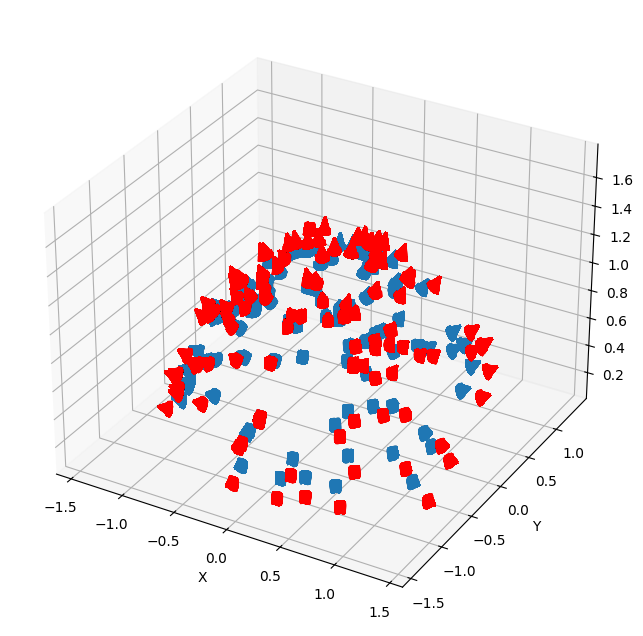

In [13]:
def plot_all_poses(poses, gt_poses):

    origins = []
    directions = []
    for pose in poses:
      ray_origins, ray_directions = get_rays(height, width, intrinsics, pose[0:3,0:3], pose[0:3,3])
      origins.append(ray_origins)
      directions.append(ray_directions)
    origins = torch.cat(origins).cpu()
    directions = torch.cat(directions).cpu()

    gt_origins = []
    gt_directions = []
    for gt_pose in gt_poses:
      ray_origins, ray_directions = get_rays(height, width, intrinsics, gt_pose[0:3,0:3], gt_pose[0:3,3])
      gt_origins.append(ray_origins)
      gt_directions.append(ray_directions)
    gt_origins = torch.cat(gt_origins).cpu()
    gt_directions = torch.cat(gt_directions).cpu()


    ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
    _ = ax.quiver(origins[..., 0].flatten(),
                  origins[..., 1].flatten(),
                  origins[..., 2].flatten(),
                  directions[..., 0].flatten(),
                  directions[..., 1].flatten(),
                  directions[..., 2].flatten(), length=0.12, normalize=True, color='red')

    _ = ax.quiver(gt_origins[..., 0].flatten(),
                  gt_origins[..., 1].flatten(),
                  gt_origins[..., 2].flatten(),
                  gt_directions[..., 0].flatten(),
                  gt_directions[..., 1].flatten(),
                  gt_directions[..., 2].flatten(), length=0.12, normalize=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('z')
    plt.show()

plot_all_poses(poses_reg, gt_poses)